# 0. Import Libraries

In [1]:
import os
import pandas as pd
import re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


# 1. Load data

In [2]:
# Define directories to take benchmark data
benchmark_dir = "/data/tmpA/andrem/benchmark"

# Define the list of tools
grn_tools = ["scenicplus", "celloracle"]

# Define the list of data integration tools
integration_tools = ["scdart", "scbridge"]

In [3]:
# Dictionary to store DataFrames: {tool: {filename: DataFrame}}
benchmark_data = {}

for tool in grn_tools:
    tool_dir = os.path.join(benchmark_dir, tool)
    tool_data = {}

    # List all .csv files in the directory
    for filename in os.listdir(tool_dir):
        if filename.endswith(".csv"):
            file_path = os.path.join(tool_dir, filename)
            
            # Read the file as a tab-separated DataFrame
            df = pd.read_csv(file_path, sep="\t")
            
            # Store in dictionary
            tool_data[filename] = df
    
    benchmark_data[tool] = tool_data


# 1. Benchmark GRN tools

# 2. Benchmark SCENIC+ pseudo-bulking

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import re
from scipy.stats import ranksums

def p_value_to_stars(p):
    """
    Convert p-value to significance stars.
    """
    if p < 0.001:
        return '***'
    elif p < 0.01:
        return '**'
    elif p < 0.05:
        return '*'
    else:
        return 'ns'

def plot_violin_comparison(benchmark_data, tool, metric, match_patterns, ylabel=None, title=None):
    """
    Plot violin + stripplot of GRN performance metric across groups matched by patterns.

    Parameters:
        benchmark_data (dict): Benchmark results dictionary
        tool (str): GRN tool name (e.g., 'scenicplus')
        metric (str): Metric to plot (e.g., 'best_fbeta', 'auprc')
        match_patterns (list of str): List of regex patterns to match filenames and group data
        ylabel (str, optional): Custom label for the y-axis. If None, defaults to f"{metric} (Avg per GRN)"
        title (str, optional): Custom plot title. If None, defaults to "{tool} Performance by Pattern"
    """
    data = []

    for filename, df_bench in benchmark_data[tool].items():
        matched_label = None
        for pattern in match_patterns:
            if re.search(pattern, filename):
                matched_label = pattern
                break

        if matched_label and metric in df_bench.columns:
            values = df_bench[metric].dropna()
            if len(values) > 0:
                avg = values.mean()
                data.append((matched_label, avg))

    if not data:
        print("No matching data found for given patterns.")
        return

    df = pd.DataFrame(data, columns=["group", "value"])
    df["group"] = pd.Categorical(df["group"], categories=match_patterns, ordered=True)

    summary = df.groupby("group", observed=True)["value"].agg(["mean", "std"]).reset_index()
    best_idx = summary["mean"].idxmax()
    best_group = summary.loc[best_idx, "group"]

    plt.figure(figsize=(10, 6))
    for group in match_patterns:
        group_data = df[df["group"] == group]
        color = "#b3cde3" if group == best_group else "lightgray"
        sns.violinplot(x="group", y="value", data=group_data, inner=None, color=color, linewidth=1)

    sns.stripplot(x="group", y="value", data=df, color='black', jitter=True, alpha=0.7)

    sns.scatterplot(x=range(len(summary)), y=summary["mean"], color="red", label="Mean", zorder=10, s=80, marker='D')

    for i, row in summary.iterrows():
        mean = row["mean"]
        std = row["std"]
        label = f"{mean:.3f} ± {std:.3f}"
        plt.text(i, mean + std + 0.01, label, ha='center', va='bottom', fontsize=10)
        tick_width = 0.15
        plt.hlines([mean - std, mean + std], xmin=i - tick_width, xmax=i + tick_width,
                   colors="gray", linestyles="--", linewidth=1)

    best_vals = df[df["group"] == best_group]["value"]
    for i, group in enumerate(summary["group"]):
        if group == best_group:
            continue
        other_vals = df[df["group"] == group]["value"]
        stat, p = ranksums(best_vals, other_vals)
        stars = p_value_to_stars(p)

        y = max(df["value"]) + 0.02 + 0.015 * i
        h = 0.005
        best_i = list(summary["group"]).index(best_group)
        other_i = i
        plt.plot([best_i, best_i, other_i, other_i], [y, y+h, y+h, y], lw=1, c='black')
        plt.text((best_i + other_i) / 2, y + h + 0.002, stars, ha='center', va='bottom', fontsize=10)

    plt.xlabel("Metacell configuration", fontsize=12)
    plt.ylabel(ylabel if ylabel else f"{metric} (Avg per GRN)", fontsize=12)
    plt.title(title if title else f"{tool.upper()} Performance by Pattern\nMetric: {metric}", fontsize=14, weight='bold')
    plt.xticks(fontsize=11, rotation=15)
    plt.yticks(fontsize=11)
    plt.grid(axis='y', linestyle='--', linewidth=0.5)
    plt.legend()
    plt.tight_layout()
    plt.show()


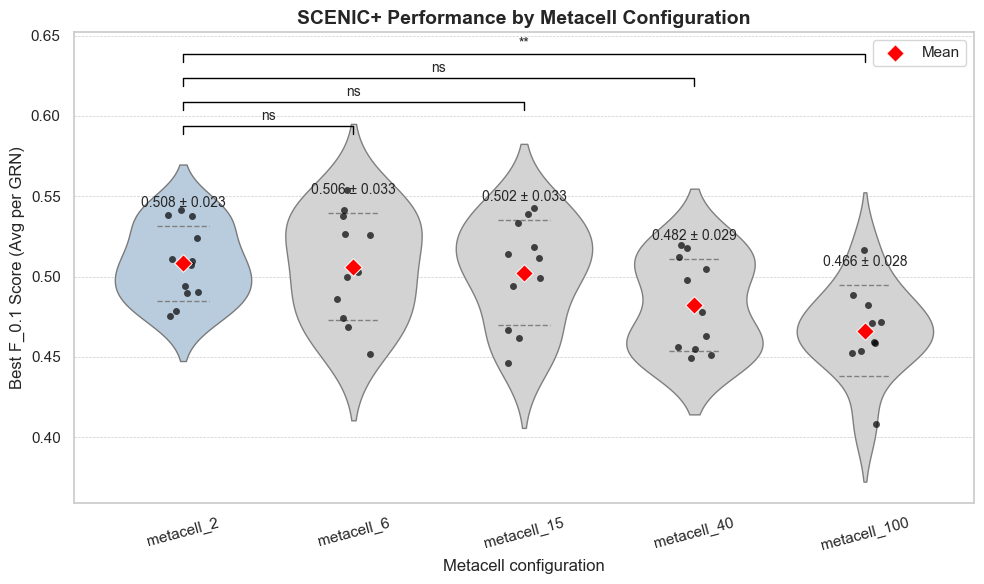

In [46]:
# Compare different metacell configurations
plot_violin_comparison(
    benchmark_data,
    tool="scenicplus",
    metric="best_fbeta",
    match_patterns=["metacell_2", "metacell_6", "metacell_15", "metacell_40", "metacell_100"],
    ylabel="Best F_0.1 Score (Avg per GRN)",
    title="SCENIC+ Performance by Metacell Configuration"
)



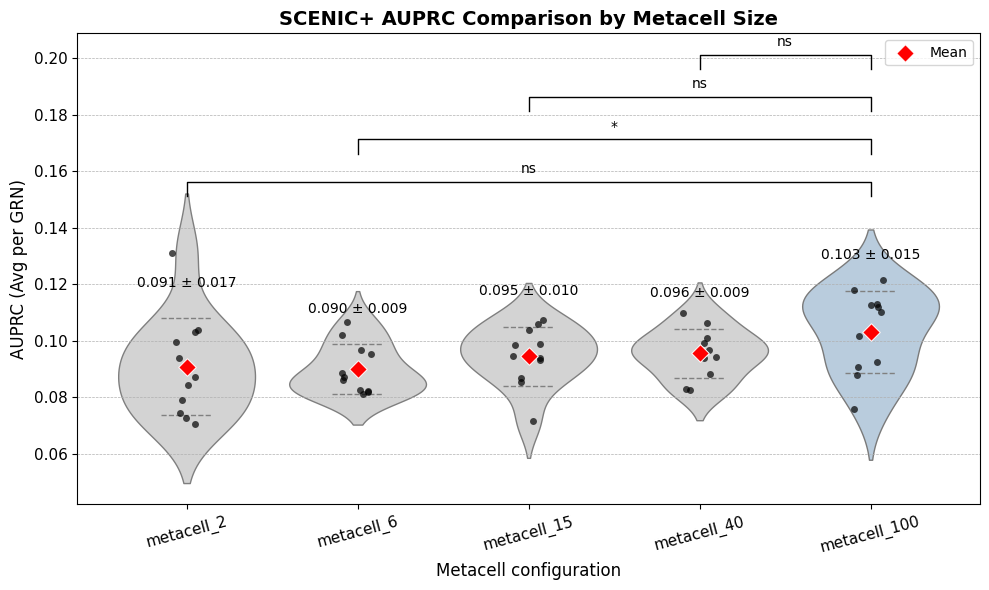

In [5]:
plot_violin_comparison(
    benchmark_data,
    tool='scenicplus',
    metric='auprc',
    match_patterns=['metacell_2', 'metacell_6', 'metacell_15', 'metacell_40', 'metacell_100'],
    ylabel='AUPRC (Avg per GRN)',
    title='SCENIC+ AUPRC Comparison by Metacell Size'
)


Note: A high AUPRC (Area Under the Precision‑Recall Curve) indicates a model’s strong ability to correctly identify positive instances, while avoiding false positives, across all threshold settings—especially important in imbalanced datasets where positive cases are rare.

# 3. Importace of scATAC (CellOracle vs others)

In [48]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import re
from scipy.stats import ranksums

def p_value_to_stars(p):
    if p < 0.001:
        return '***'
    elif p < 0.01:
        return '**'
    elif p < 0.05:
        return '*'
    else:
        return 'ns'

def plot_tool_filter_comparison(benchmark_data, tool_filters_dict, metric, ylabel=None, title=None):
    """
    Plot bar plot of GRN performance metric comparing multiple tool+filter combinations.

    Parameters:
        benchmark_data (dict): Benchmark results dictionary
        tool_filters_dict (dict): Dict mapping tool -> list of regex filters for filename
        metric (str): Metric to plot (e.g., 'best_fbeta', 'auprc')
        ylabel (str, optional): Custom label for the y-axis
        title (str, optional): Custom plot title
    """
    data = []

    for tool, filters in tool_filters_dict.items():
        if tool not in benchmark_data:
            continue
        for pattern in filters:
            label = f"{tool}:{pattern}"
            for filename, df_bench in benchmark_data[tool].items():
                if re.search(pattern, filename) and metric in df_bench.columns:
                    values = df_bench[metric].dropna()
                    if len(values) > 0:
                        avg = values.mean()
                        data.append((label, avg))

    if not data:
        print("No matching data found.")
        return

    df = pd.DataFrame(data, columns=["label", "value"])
    df["label"] = pd.Categorical(df["label"], categories=sorted(set(df["label"])), ordered=True)

    summary = df.groupby("label", observed=True)["value"].agg(["mean", "std"]).reset_index()
    best_idx = summary["mean"].idxmax()
    best_label = summary.loc[best_idx, "label"]

    plt.figure(figsize=(10, 6))
    x = range(len(summary))
    bar_colors = ["#4F81BD" if label == best_label else "#D9D9D9" for label in summary["label"]]

    plt.bar(x, summary["mean"], yerr=summary["std"], capsize=6,
            color=bar_colors, edgecolor="black")

    # Annotate bars
    for i, row in summary.iterrows():
        label_text = f"{row['mean']:.3f} ± {row['std']:.3f}"
        plt.text(i, row["mean"] + row["std"] + 0.01, label_text, ha='center', va='bottom', fontsize=10)

    # P-test between best and others
    best_vals = df[df["label"] == best_label]["value"]
    for i, label in enumerate(summary["label"]):
        if label == best_label:
            continue
        other_vals = df[df["label"] == label]["value"]
        stat, p = ranksums(best_vals, other_vals)
        stars = p_value_to_stars(p)

        y = max(df["value"]) + 0.02 + 0.015 * i
        h = 0.005
        best_i = list(summary["label"]).index(best_label)
        other_i = i
        plt.plot([best_i, best_i, other_i, other_i], [y, y+h, y+h, y], lw=1, c='black')
        plt.text((best_i + other_i) / 2, y + h + 0.002, stars, ha='center', va='bottom', fontsize=10)

    # Final styling
    plt.xticks(ticks=x, labels=summary["label"], rotation=25, ha='right', fontsize=11)
    plt.yticks(fontsize=11)
    #plt.xlabel("Tool + Filter", fontsize=12)
    plt.ylabel(ylabel if ylabel else f"{metric} (Avg per GRN)", fontsize=12)
    plt.title(title if title else f"Performance Comparison by Tool+Filter\nMetric: {metric}", fontsize=14, weight='bold')
    plt.grid(axis='y', linestyle='--', linewidth=0.5)
    plt.tight_layout()
    plt.show()


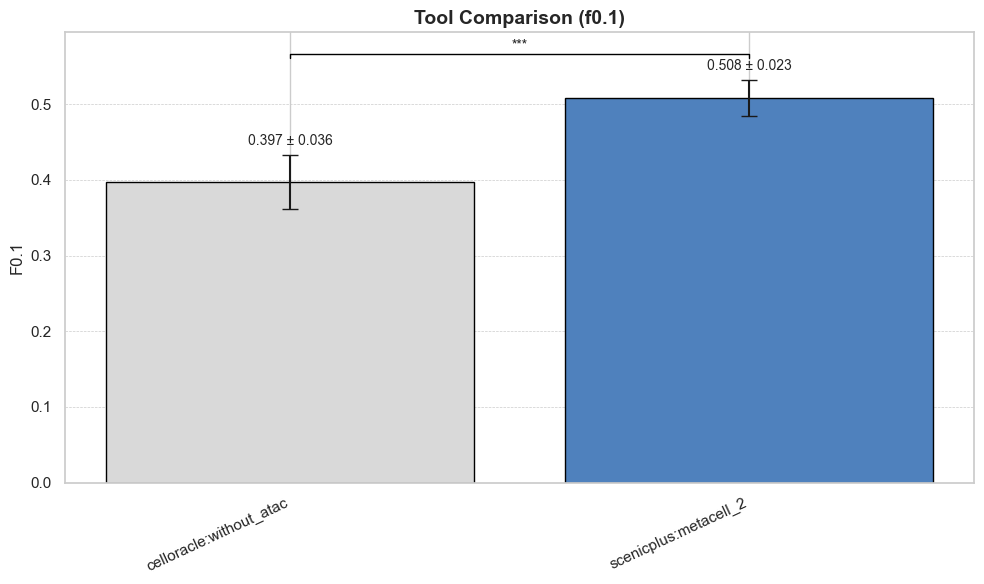

In [49]:
tool_filters = {
    "scenicplus": ["metacell_2"],
    "celloracle": ["without_atac"]
}

plot_tool_filter_comparison(benchmark_data, tool_filters, metric="best_fbeta", ylabel="F0.1", title="Tool Comparison (f0.1)")


# 4. Dataset leaderboard